In [19]:
#imports
import sys
import scipy.constants as con
import scipy.optimize as opt
#import scipy as sp
import numpy as np
from scipy import special
from scipy import integrate
from scipy.optimize import root_scalar
from scipy.integrate._ivp import common as jacpack

import matplotlib.pyplot as plt

import pynucastro as pyna
reaclibrary = pyna.ReacLibLibrary()

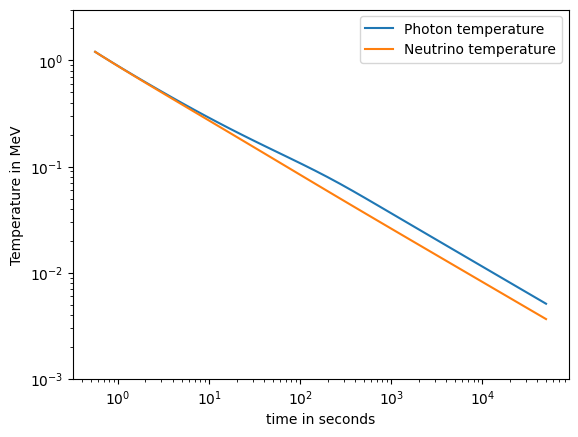

In [170]:
#Background
#Special functions og deres afledte
def L(z):
    return special.kn(2,z)/z

def M(z):
    return (3/4*special.kn(3,z)+1/4*special.kn(1,z))/z

def dMdz(z):
    return -3/z**2*special.kn(3,z) -special.kn(2,z)/z

def N(z):
    return (1/2*special.kn(4,z)+1/2*special.kn(2,z))/z


timeunit =1.519*10**21  #MeV/hbar in unit of 1/second 

n_life=879.6*timeunit   #Neutron lifetime in units of MeV/hbar
Q=1.293                 #neutron proton mass difference in MeV
M_u=931                 #atomic mass unit in MeV
SBC=np.pi**2/60         #Stefan-Boltzmann constant in natural units
G=6.709e-45             #gravatational constant in units of c=hbar=MeV=1
#infapprox=1e3           #large number acting as upper limit on itegrals
n_nu=3.046              #number of neutrino families with correction from 
                        #Nollett and Steigman, BBN and the CMB constrain neutrino coupled light WIMPs, 2015

TMeV2T9=11.60451812 #conversion factor from MeV to 10^9K
cm3s=1.167*10**-11  #conversion factor for cm^3/s
gcm3=232012         #conversion factor for g/cm^3
meter=5.068e12      #conversion factor for m
cm=5.068e10         #conversion factor for cm
barn=389.4          #conversion factor for barn
T_ini=1.2           #initial temperature in MeV
e_mass=0.51099895   #electron mass in MeV
z_ini=e_mass/T_ini

def rho_e(T): #electron/positron density, chemical potential assumed to be 0 so cosh(phi*n)=1
    z=e_mass/T
    '''
    func=lambda x: np.real(2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)/((np.exp(z*x)+1))))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)*M(n*z) for n in range(1,10)])

def drho_e(T): #derivative of rho_e with respect to temperature
    z=e_mass/T
    '''
    func=lambda x: np.real(2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)*(z*x*np.exp(z*x))/(T*(np.exp(z*x)+1)**2)))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n)*n*z/T*dMdz(n*z) for n in range(1,10)])


def P_e(T): #electron/positron pressure
    z=e_mass/T
    '''
    func=lambda x: 2/(3*np.pi**2)*e_mass**4*((x**4*(x**2+1)**-0.5)/((np.exp(z*(x**2+1)**0.5)+1)))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    #Fowler and Hoyle 1964
    #return 4/np.pi**2*T**4*np.sum([(-1)**(n+1)/n**4*special.kn(2,n*z) for n in range(1,10)])
    
    #Kawano
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)/(n*z)*L(n*z) for n in range(1,10)])  



def rho_gamma(T):   #photon energy density
    return (np.pi**2)/15*T**4 

def drho_gamma(T):  #derivative
    return 4*(np.pi**2)/15*T**3 

def P_gamma(T):     #photon pressure
    return rho_gamma(T)/3



### Initial conditions ###

n_gamma_ini= 1.20206*2/np.pi**2*T_ini**3    #initial number density of photons based on theory
n_gamma_ini= rho_gamma(T_ini)/(2.701*T_ini) #initial number density of photons based mean photon energy

eta=6.1e-10     #CMB baryon-to-photon ratio
eta_ini=eta*(1+(rho_e(T_ini)+P_e(T_ini))/(rho_gamma(T_ini)+P_gamma(T_ini))) #entropi bevarelse


rho_nu_ini=n_nu*7/8*(np.pi**2)/15*T_ini**4 #initial neutrino density

h_ini=M_u/T_ini**3*eta_ini*n_gamma_ini  #initial h

t_ini=1.226*10**21/T_ini**2 #initial time in hbar/MeV

rho_b_ini=h_ini*T_ini**3     #initial baryon density, currently set to 0

rho_tot_ini=rho_e(T_ini)+rho_gamma(T_ini)+rho_nu_ini+rho_b_ini  #initial total energy density

H_ini=np.sqrt(8*np.pi/3*G*rho_tot_ini)


def rho_nu(T,a): #neutrina energy density
    #return 7/8*np.pi**2/15*T**4
    return rho_nu_ini/a**4

def rho_b(T,a):
    return h_ini*T_ini**3/a**3



#def P_b(T,h):
#    return h*T**4*2/3*

#Phie_ini=np.pi**2/2*con.Avogadro*h_ini/z_ini**3*1/sum([(-1)**(n+1)*n*L(n*z_ini) for n in range(1,20)]) 




### Solving the background ###

def rho_tot(T,a): #total density
    return rho_e(T)+rho_gamma(T)+rho_nu(T,a)+rho_b(T,a)

def rho_set(T,a): #total density of non-decoupled components
    return rho_e(T)+rho_gamma(T)+rho_b(T,a)

def H(T,a):   #Hubble parameter as given by Friedmann eq, ignoring cosmological constant
    return np.sqrt(8*np.pi/3*G*rho_tot(T,a))

#Derivative from Kavano D.18
def dTdt(t,T,a):
    return -3*H(T,a)/((drho_e(T)+drho_gamma(T))/(rho_set(T,a) + P_e(T)+P_gamma(T)))

#Derivative from Kavano D.19
def dhdt(t,T,h,a):
    return -3*h*(H(T,h,a)+dTdt(t,T,h,a)/T)

#Derivative from how H is defined
def dadt(t,T,a):
    return a*H(T,a)


#Derivatives for Jacobian

def dadT(T,a):
    return -((drho_e(T)+drho_gamma(T))/(rho_set(T,a) + P_e(T)+P_gamma(T)))*a/3

def drho_nu(T,a): #neutrina energy density
    return -rho_nu_ini*4/a**5

def drho_b(T,a):
    return -h_ini*T_ini**3*3/a**4

def rho_totdT(T,a): #total density
    return drho_e(T)+drho_gamma(T)+(drho_nu(T,a)+drho_b(T,a))*dadT(T,a)

def rho_totda(T,a): #total density
    return (drho_e(T)+drho_gamma(T))/dadT(T,a)+drho_nu(T,a)+drho_b(T,a)



def HdT(T,a):   #Hubble parameter deriv with respect to Temperature
    return 4*np.pi/3*G*rho_totda(T,a)/H(T,a)

def Hda(T,a):   #Hubble parameter deriv with respect to Scale factor
    return 4*np.pi/3*G*rho_totdT(T,a)/H(T,a)

def dadtda(t,T,a):
    return H(T,a)+a*Hda(T,a)


def dadtdT(t,T,a):
    return dadT(T,a)*H(T,a)+a*HdT(T,a)



t_range=[t_ini,5e4*timeunit]            #time range for integration
#t_space=np.linspace(*t_range,1000)      #time range for approximate temperature

#combining derivatives
def dbackground(t,y):   #solve h and T, y[0] = T, y[1] = a
    return [dTdt(t,*y),dadt(t,*y)]



# Solving it
sol = integrate.solve_ivp(dbackground, t_range, [T_ini,1],method='Radau')#,t_eval=t_space)

plt.figure()
# Plot the Temperature
plt.plot(sol.t/timeunit, sol.y[0], label='Photon temperature')

# Test with completely radiation dominated universe
t_space=sol.t
T_approx=np.sqrt(1.226*10**21/t_space)
#T_approx=1/np.sqrt(t_space/timeunit)/10.4*TMeV2T9
plt.plot(t_space/timeunit, T_ini/sol.y[1], label='Neutrino temperature')


#plot the scale factor
#plt.plot(sol.t/timeunit, sol.y[2]/1e3, label='scale factor')

#fix the axis
plt.xlabel('time in seconds')
plt.ylabel('Temperature in MeV')

plt.xscale('log')
plt.yscale('log')

# plt.xlim((0.1, 2e5))
plt.ylim((1e-3,3))

plt.legend()
plt.show()

#plt.figure


n_bparams=2


<Figure size 640x480 with 0 Axes>

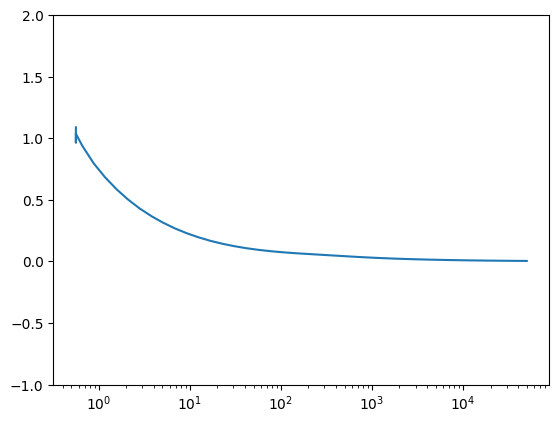

In [171]:
#test of numerical to analytical gradients


#dadtda(t,T,a)

a=sol.y[1]
T=sol.y[0]

rho_totdT(T_ini,a)

dB2 = np.gradient(a, t_space)

fig2=plt.figure()

#plt.ylim([-1,2])
#print(dB2)
#print(dB2(0.5))

#plt.plot(t_space/timeunit,dadt(t_space,T,a)/dB2)
#plt.plot(T,1/a)
#plt.plot(z,dB2,'--')


#z=np.linspace(0,0.1,10000)
'''
dB2 = np.gradient([ dadT(T2,a) for T2 in T], T)

fig2=plt.figure()

plt.ylim([-1,2])
#print(dB(0.5))
#print(dB2(0.5))

plt.plot(t_space/timeunit,[drho_e(T2) for T2 in T]/dB2)
'''


dB2 = np.gradient(a, T)

fig2=plt.figure()

plt.ylim([-1,2])
#print(dB(0.5))
#print(dB2(0.5))

plt.plot(t_space/timeunit,dadT(T,a)/dB2)

plt.xscale('log')

#print([rho_e(T2) for T2 in T])




In [172]:
a

array([  1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.00000001,   1.00000002,   1.0000001 ,   1.00000094,
         1.00000937,   1.00009365,   1.00093601,   1.00932112,
         1.08964264,   1.27458734,   1.48166358,   1.72949758,
         2.0014137 ,   2.32830276,   2.7135509 ,   3.13779384,
         3.65503579,   4.26593121,   4.94129911,   5.76805206,
         6.74971041,   7.84080948,   9.18243609,  10.78515031,
        12.5747323 ,  14.77822865,  17.41486935,  20.35570419,
        23.96117764,  28.24364227,  32.96695796,  38.64959863,
        45.21109428,  52.32045015,  60.90996686,  70.99747992,
        82.08261783,  95.54972411, 111.42219713, 128.89519475,
       150.14694891, 175.23565968, 202.90362792, 236.6112022 ,
       276.50358523, 320.61621431, 326.79628591])

In [173]:
import bbn_test_integrate as bbn_n
#import He4_test_integrate as He4_n


In [218]:
#Initial conditions for Y

#mass of various nuclei converted to MeV
m_n  =  1.0086649159  *M_u
m_p  =  1.00782503190 *M_u
m_d  =  2.01410177784 *M_u
m_t  =  3.01604928132 *M_u
m_He3 = 3.01602932197 *M_u
m_He4 = 4.00260325413 *M_u

#equilibrium ratios for simple rates #Pebbles
def G_np(T,a):

    N=eta_ini*n_gamma_ini/a**3 #number density
    return 4/3*(m_n*m_p*T/(2*np.pi*m_d))**1.5/N*np.exp((m_d-m_n-m_p)/T)

def G_nHe3(T):
    return 9/4*(m_d**2/(m_He3*m_n))**1.5*np.exp((m_n+m_He3-2*m_d)/T)

def G_tp(T):
    return 9/4*(m_d**2/(m_t*m_p))**1.5*np.exp((m_p+m_t-2*m_d)/T)  

def G_tp_nHe3(T):
    return ((m_He3*m_n)/(m_t*m_p))**1.5*np.exp((m_p+m_t-(m_n+m_He3))/T)

def G_nHe4(T):
    return 3*((m_d+m_t)/(m_He4*m_n))**1.5*np.exp((m_He4+m_n-m_d-m_t)/T)  

#Initial conditions
nNucs=9
Y_ini=np.zeros(nNucs)+1e-40
#Y_ini=np.array([1e-20 for i in range(nNucs)])

Xn_ini = 1/(np.exp(Q/T_ini)+1)

#Initial condition based on thermal equilibrium amongst in the most important reactions

Y_ini[0] = Xn_ini        #Set initial neutron mass fraction
Y_ini[1] = 1 - Xn_ini    #Set initial proton mass fraction
Y_ini[2] = Y_ini[0]*Y_ini[1]/G_np(T_ini,1)          #Set initial deuterium mass fraction
Y_ini[3] = Y_ini[2]**2/Y_ini[1]/G_tp(T_ini)
Y_ini[4] = Y_ini[2]**2/Y_ini[0]/G_nHe3(T_ini)
#Y_ini[5] = Y_ini[2]*Y_ini[3]/Y_ini[0]/G_nHe4(T_ini)
print(Y_ini)

#compile rhs
bbn_n.rhs(t_ini/timeunit, Y_ini,eta_ini*n_gamma_ini*1*gcm3, T_ini*TMeV2T9*1e9)

dYdt_ini=lambda Y : bbn_n.rhs(t_ini/timeunit, Y ,eta_ini*n_gamma_ini*m_p*gcm3, T_ini*TMeV2T9*1e9)

#Find initial conditions from rhs
Y_initial=opt.fsolve(dYdt_ini, x0=Y_ini)

#use these initial conditions. Currently won't converge
Y_ini[5:]=abs(Y_initial/sum(Y_initial))[5:]
#rhs(t, Y, rho, T):
#Y_ini[6]=abs(Y_initial/sum(Y_initial))[6]*0.9
#Y_ini[8]=abs(Y_initial/sum(Y_initial))[8]*0.9

print(abs(Y_initial/sum(Y_initial)))
print(sum(Y_initial))
print(dYdt_ini(Y_ini))


[2.53979410e-01 7.46020590e-01 7.43485809e-13 6.14184283e-24
 9.56145159e-24 1.00000000e-40 1.00000000e-40 1.00000000e-40
 1.00000000e-40]
[2.52911058e-01 7.47088942e-01 7.52232287e-13 6.29893060e-24
 9.84106040e-24 2.07173498e-27 1.73881591e-35 3.70465980e-36
 3.59483161e-35]
0.9930061632774643
[-3.21495619e+01 -3.21392038e+01  3.21443829e+01  7.43717174e-12
  1.29254267e-11 -1.66673036e-18 -5.91673436e-22 -7.15320211e-21
 -1.86201490e-20]


In [219]:
sparcity=np.zeros((10,10))+1
sparcity[3:,:3]=0
sparcity[:3,3:]=2
#sparcity[0,0]=0
print(sparcity)

[[1. 1. 1. 2. 2. 2. 2. 2. 2. 2.]
 [1. 1. 1. 2. 2. 2. 2. 2. 2. 2.]
 [1. 1. 1. 2. 2. 2. 2. 2. 2. 2.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]]


In [249]:
jac=bbn_n.jacobian(t_ini/timeunit, Y_ini,eta_ini*n_gamma_ini*1*m_p*gcm3, T_ini*TMeV2T9*1e9)
jac=np.append(np.zeros((nNucs,n_bparams)),jac,axis=1)
np.append(np.zeros((n_bparams,n_params)),jac,axis=0)



array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -5.95427766e+03,
        -2.02464847e+03,  1.98954667e+15,  4.82370351e+13,
        -3.14616649e+07,  1.63525478e+08,  1.17099345e+14,
         1.23331429e+13, -8.54663407e+07],
       [ 0.00000000e+00,  0.00000000e+00, -5.94703432e+03,
        -2.02710055e+03,  1.98954667e+15, -4.88375959e+07,
         5.88371291e+13,  6.56620175e+08,  1.17099248e+14,
        -3.64729407e+07,  4.11757417e+13],
       [ 0.00000000e+00,  0.00000000e+00,  5.95065599e+03,
         2.02587451e+03, -1.98954667e+15,  4.82369879e+13,
  

In [221]:
#Combining background and network

        # enumeration for different isotopes
        #  0   1   2   3    4     5     6     7     8
Y_labels=['n','p','d','t','He3','He4','Li6','Li7','Be7']
'''
step=20
print(solY.t[step]/timeunit)
print(solY.y.T[step])
initial_param=solY.y.T[step]
t_range=[solY.t[step],5e4*timeunit]
'''
initial_param=[T_ini,1]+list(Y_ini)
t_range=[t_ini,5e4*timeunit]

n_params=nNucs+n_bparams
sparcity=None#np.zeros((n_params,n_params))+1
#sparcity[:3,3:]=0
#sparcity[n_bparams:,:n_bparams]=0
def ndbackground(t,y):   #solve h and T, y[0] = T, y[1] = h and y[2] = a
    return [dTdt(t,*y),dadt(t,*y)]

def ndall(t,y):   #solve h and T, y[0] = T and y[1] = a   
    #print(ndbackground(t,y[:n_bparams])+list( bbn_n.rhs(t/timeunit, y[n_bparams:],eta_ini*n_gamma_ini/y[2]**3*m_p*gcm3, y[0]*TMeV2T9*1e9)/timeunit))
                     
    return ndbackground(t,y[:n_bparams])+list( bbn_n.rhs(t/timeunit, y[n_bparams:],eta_ini*n_gamma_ini/y[1]**3*m_p*gcm3, y[0]*TMeV2T9*1e9)/timeunit)



In [252]:
#solving with costum jacobian


def jacY_anal(t,y):
    return bbn_n.jacobian(t/timeunit, y[n_bparams:],eta_ini*n_gamma_ini/y[1]**3*m_p*gcm3, y[0]*TMeV2T9*1e9)/timeunit



def jacfun(t,x):
    return np.array([ndall(t,row)  for row in x.T]).T

Factor=None
def jacobian(t,y):
    '''
    global Factor
    jac_rhs_value=np.array(ndall(t,y))
    jactest=jacpack.num_jac(jacfun,t,y,jac_rhs_value,1e-30,Factor)
    Factor=jactest[1]
    jactest[0][:,:] = np.zeros((n_params,n_params))
    jactest[0][2:,:] = np.zeros((nNucs,n_params))
    jactest[0][:,2:] = np.zeros((n_params,nNucs))
    jactest[0][2:,2:]=jacY_anal(t,y)
    
    
    return jactest[0]
    '''
    jac=np.append(np.zeros((nNucs,n_bparams)),jacY_anal(t,y),axis=1)
    return np.append(np.zeros((n_bparams,n_params)),jac,axis=0)
    

jacsolY = integrate.solve_ivp(ndall, t_range, initial_param,method='Radau',atol=1e-30,rtol=1e-4,jac=jacobian)#,t_eval=t_space)


abun=[abun[-1] for abun in jacsolY.y[n_bparams:]]


print([abun[0],abun[1],2*abun[2],3*abun[3],3*abun[4],4*abun[5]])
print('sum: ',abun[0]+abun[1]+2*abun[2]+3*abun[3]+3*abun[4]+4*abun[5])

[7.161499355367137e-11, 0.760942944713184, 3.762291690346541e-05, 1.8219726524224248e-07, 2.3330884255991517e-05, 0.23899591673809964]
sum:  0.9999999975213234


In [253]:
#Solving without jacobian

nsolY = integrate.solve_ivp(ndall, t_range, initial_param,method='Radau',atol=1e-30,rtol=1e-4,jac_sparsity=sparcity)#,t_eval=t_space)
jacabun=abun
print(np.array(abun)/np.array(jacabun))
abun=[abun[-1] for abun in nsolY.y[n_bparams:]]
print([abun[0],abun[1],2*abun[2],3*abun[3],3*abun[4],4*abun[5]])
print('sum: ',abun[0]+abun[1]+2*abun[2]+3*abun[3]+3*abun[4]+4*abun[5])

[1. 1. 1. 1. 1. 1. 1. 1. 1.]
[7.161340744423279e-11, 0.7609429435416436, 3.762291328831749e-05, 1.821972663227393e-07, 2.3330884299456457e-05, 0.23899591616832463]
sum:  0.9999999957764357


In [254]:
print('Yp    = '+str(4*abun[5]/abun[1]))
print('H2/H  = '+str(2*abun[2]/abun[1]))
print('H3/H  = '+str(3*(abun[3]+abun[4])/abun[1]))
print('Li7/H = '+str(7*(abun[7])/abun[1]))
print('Li6/H = '+str(6*(abun[6])/abun[1]))
print('Be7/H = '+str(7*(abun[8])/abun[1]))

Yp    = 0.3140786286235471
H2/H  = 4.9442489226866096e-05
H3/H  = 3.0899927209184266e-05
Li7/H = 1.9795982748240087e-10
Li6/H = 4.201215538070238e-14
Be7/H = 3.0613511845422844e-09


In [255]:
#print(nsolY)
#print(nsolY.t[255]/timeunit)
#print(nsolY.y[:,255])


In [256]:
#test of analytical jacobian

jacvalues=nsolY.y[:,255]

jac_rhs_value=np.array(ndall(1,jacvalues))
'''
jactest1=jacpack.num_jac(jacfun,t_ini,initial_param,rhs_value_ini,1e-30,None)
print(jactest1)
jactest2=jacpack.num_jac(jacfun,t_ini,initial_param,rhs_value_ini,1e-30,jactest1[1])
print(jactest2)
'''


#sparcity=np.zeros((n_params,n_params))+1
#sparcity[:3,3:]=0
#sparcity[n_bparams:,:n_bparams]=0

Factor=None
for i in range(6):
    
    jactest=jacpack.num_jac(jacfun,t_ini,jacvalues,jac_rhs_value,1e-30,Factor)
    if Factor is not None:
        print(Factor-jactest[1])
    Factor=jactest[1]
print(jactest[0][2:,2:]*timeunit)

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.34110451e-05
 -1.47521496e-04 -1.34110451e-05  0.00000000e+00]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.00013411 0.         0.        ]
[ 0.          0.          0.          0.          0.          0.
  0.          0.         -0.00013411  0.          0.        ]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.00013411 0.         0.        ]
[ 0.          0.          0.          0.          0.          0.
  0.          0.         -0.00013411  0.          0.        ]
[[-3.94384873e-01 -5.44542453e-02  5.38451065e+01  7.94488606e+00
  -9.94736602e+02  0.00000000e+00 -9.35722363e+02  1.23561231e-01
   0.00000000e+00]
 [-3.90517317e-01 -5.44801424e-02  5.36361425e+01 -4.60150460e-01
   9.95790814e+02  0.00000000e+00  0.00000000e+00 -2.87725743e+00
   0.00000000e+00]
 [ 3.92431184e-01  5.44602715e-0

In [257]:
#test of analytical jacobian
jac=bbn_n.jacobian(t_ini/timeunit, jacvalues[2:],eta_ini*n_gamma_ini/jacvalues[1]**3*m_p*gcm3, jacvalues[0]*TMeV2T9*1e9)
#np.append(np.zeros((nNucs,n_bparams)),jac,axis=1)
print(jac)
print((jactest[0][2:,2:]*timeunit)/jac)#*timeunit)

[[-3.94384878e-01 -5.44542451e-02  5.38451068e+01  7.94488606e+00
  -9.94661864e+02 -1.07934617e-25 -7.88142986e+02  1.23462514e-01
  -3.85272339e+03]
 [-3.90517312e-01 -5.44801433e-02  5.36361425e+01 -4.60136472e-01
   9.95790668e+02 -1.07912101e-25 -7.78191050e+01 -2.87643024e+00
   3.70832963e+03]
 [ 3.92431180e-01  5.44602713e-02 -5.43707971e+01 -7.51063850e+00
  -1.13108168e+00 -8.06681760e-10  3.78516060e+00 -1.17788648e-01
  -4.60827641e-02]
 [ 8.06959176e-04 -1.11588221e-05 -1.50543829e-02 -7.97689727e+00
   9.94657146e+02 -5.71501762e-08  7.88714472e+02  3.20678253e-02
  -7.38973733e-04]
 [-7.93686805e-04  1.47392177e-05  1.93909920e-01  4.28129644e-01
  -9.95795387e+02 -1.43344031e-11  7.84949921e+01 -1.69682442e-07
   1.42507313e+02]
 [ 3.37937628e-09  7.76333437e-07  1.80944573e-01  7.54569991e+00
   1.13701984e+00 -5.79711923e-08  8.72262107e+02  6.02894109e+00
   4.31483598e+02]
 [-9.76102096e-12 -1.34821317e-13  1.48755724e-09  4.03303088e-26
   9.21004282e-24  8.0668176

In [258]:
jactest[0]

array([[-2.87452923e-24,  4.57993870e-27, -0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 5.55484512e-22,  2.73850514e-25, -0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 1.17302439e-20,  4.50289361e-24, -2.59634544e-22,
        -3.58487461e-23,  3.54477331e-20,  5.23033974e-21,
        -6.54862806e-19,  0.00000000e+00, -6.16012089e-19,
         8.13437991e-23,  0.00000000e+00],
       [ 1.17286087e-20,  4.50279613e-24, -2.57088424e-22,
        -3.58657949e-23,  3.53101663e-20, -3.02929862e-22,
         6.55556823e-19,  0.00000000e+00,  0.00000000e+00,
        -1.89417869e-21,  0.00000000e+00],
       [-1.17317632e-20, -4.47232545e-24,  2.58348377e-22,
         3.58527133e-23, -3.57938093e-20, -4.94445727e-21,
  

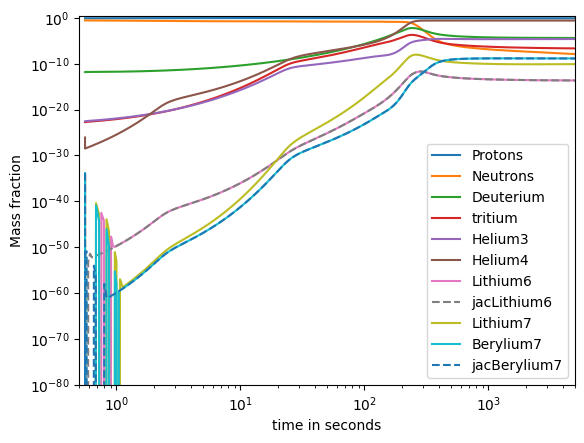

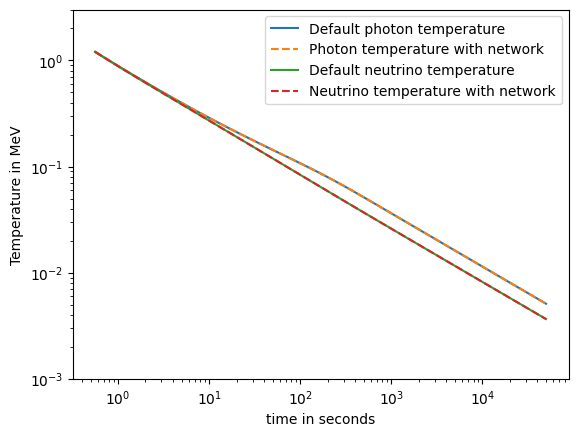

In [259]:
# Plot the results
plt.figure('abundance')
plt.plot(nsolY.t/timeunit, nsolY.y[n_bparams+1], label='Protons')
plt.plot(nsolY.t/timeunit, nsolY.y[n_bparams], label='Neutrons')
#plt.plot(solY.t/timeunit, -solY.y[n_bparams+1], label='-Neutrons')
plt.plot(nsolY.t/timeunit, 2*nsolY.y[n_bparams+2], label='Deuterium')
#plt.plot(solY.t/timeunit, -2*solY.y[n_bparams+2], label='-Deuterium')
plt.plot(nsolY.t/timeunit, 3*nsolY.y[n_bparams+3], label='tritium')
plt.plot(nsolY.t/timeunit, 3*nsolY.y[n_bparams+4], label='Helium3')
plt.plot(nsolY.t/timeunit, 4*nsolY.y[n_bparams+5], label='Helium4')
plt.plot(nsolY.t/timeunit, 4*nsolY.y[n_bparams+6], label='Lithium6')
plt.plot(jacsolY.t/timeunit, 4*jacsolY.y[n_bparams+6],'--', label='jacLithium6')
plt.plot(nsolY.t/timeunit, 4*nsolY.y[n_bparams+7], label='Lithium7')

plt.plot(nsolY.t/timeunit, 4*nsolY.y[n_bparams+8], label='Berylium7')
plt.plot(jacsolY.t/timeunit, 4*jacsolY.y[n_bparams+8],'--', label='jacBerylium7')
#plt.plot(solY.t/timeunit, [1e-4 for t in solY.t], 'k+',label='eval test')
#plt.plot(sol.t, sol.y[3]/sol.y[2], label='n/p')

#print(solY.y[n_bparams:])
#print(solY)
plt.xlabel('time in seconds')
plt.ylabel('Mass fraction')
plt.ylim(1e-80,3)
plt.xlim(0.5,5e3)

plt.xscale('log')
plt.yscale('log')

#plt.xlim((1, 5e4))
#plt.ylim((1e-10,1.1))

plt.legend()
plt.show()

plt.figure('temperature')

# Plot the Temperature
plt.plot(sol.t/timeunit, sol.y[0], label='Default photon temperature')
plt.plot(nsolY.t/timeunit, nsolY.y[0],'--', label='Photon temperature with network')

# Test with completely radiation dominated universe
#t_space=solY.t
#T_approx=np.sqrt(1.226*10**21/t_space)
#T_approx=1/np.sqrt(t_space/timeunit)/10.4*TMeV2T9
plt.plot(sol.t/timeunit, T_ini/sol.y[1], label='Default neutrino temperature')
plt.plot(nsolY.t/timeunit, T_ini/nsolY.y[1],'--', label='Neutrino temperature with network')

#plot the scale factor
#plt.plot(sol.t/timeunit, sol.y[2]/1e3, label='scale factor')

#fix the axis
plt.xlabel('time in seconds')
plt.ylabel('Temperature in MeV')

plt.xscale('log')
plt.yscale('log')

# plt.xlim((0.1, 2e5))
plt.ylim((1e-3,3))

plt.legend()
plt.show()
